# Sum(Text) Demo

To see the demo, please run all the blocks and check the final block output. You can click the link in the output and you should be able to see something similar to the picture below. 

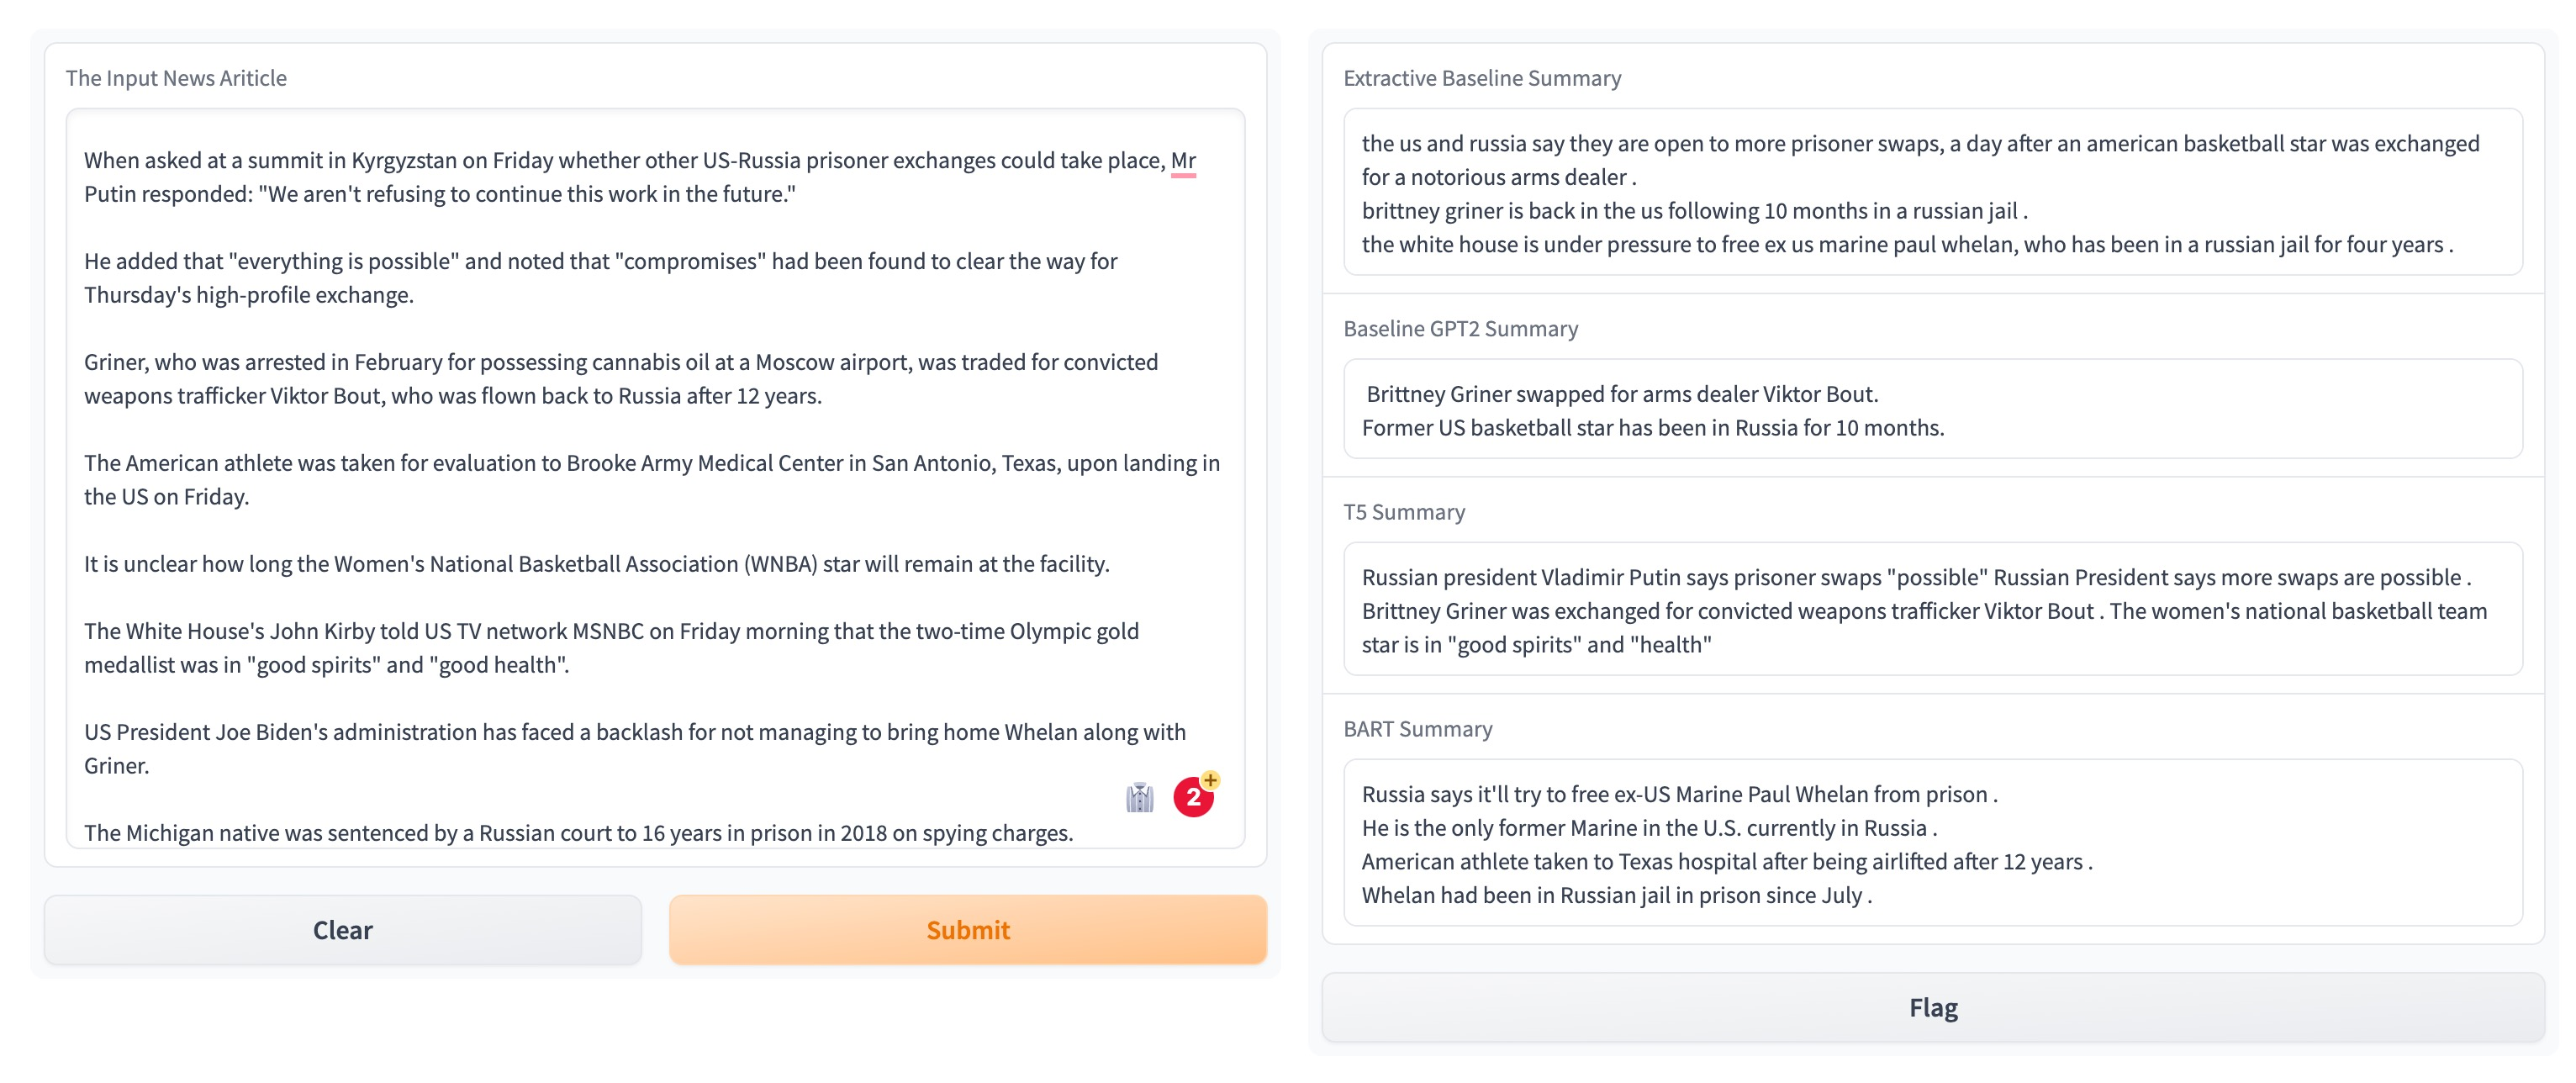

Feel free to paste some news articles of your own choice on the left side and click the submit button! That's when the magic happens! Wait and see how different summarizers summarize the article on the right side! 

In [1]:
%%capture
!pip install transformers
!pip install sentencepiece

In [2]:
import transformers
import pandas as pd
import numpy as np
import torch
from IPython.display import display, HTML
from transformers import pipeline, GPT2Tokenizer,GPT2LMHeadModel
import re

import nltk

nltk.download("punkt")

from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

## Loading Models

In [ ]:
# Load Trained Model - Bart Finetuned Model
hub_model_id_bart = "Alred/bart-base-finetuned-summarization-cnn-ver1.3"
bart_summarizer = pipeline("summarization", model=hub_model_id_bart, num_beams=6, no_repeat_ngram_size=3, temperature=2., do_sample=True)

Downloading:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/558M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/384 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/280 [00:00<?, ?B/s]

In [ ]:
# Load Trained Model - T5 Finetuned Model
hub_model_id_t5 = "Alred/t5-base-finetuned-summarization-cnn-ver2"
t5_summarizer = pipeline("summarization", model=hub_model_id_t5, temperature=2., do_sample=True)

Downloading:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/892M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

In [ ]:
# Load Baseline-gpt2 Model
model_gpt2 = GPT2LMHeadModel.from_pretrained('gavin124/gpt2-finetuned-cnn-summarization-v2')
tokenizer_gpt2 = GPT2Tokenizer.from_pretrained('gavin124/gpt2-finetuned-cnn-summarization-v2')

def gpt2_summerizer(text):
    max_input_length = 1024
    max_target_length = 128
    token_txt = tokenizer_gpt2(text)['input_ids']
    if len(token_txt) >= 900:
        token_txt2 = token_txt[:900]
    text = tokenizer_gpt2.decode(token_txt2)

    prompt = '<|startoftext|>' + text +'<|summarize|>'
    generated = tokenizer_gpt2(prompt, return_tensors="pt", truncation=True, max_length=max_input_length)
    generated_ids = generated.input_ids
    attention_mask = generated.attention_mask

    sample_outputs = model_gpt2.generate(generated_ids, attention_mask= attention_mask, pad_token_id=tokenizer_gpt2.pad_token_id,max_length = max_input_length,
                                    do_sample=True, top_k=50, top_p=0.90, temperature=0.8 )

    pred_text = tokenizer_gpt2.decode(sample_outputs[0], skip_special_tokens = False)

    try:
        pred_summary = pred_text.split("<|summarize|>", 1)[1]
        pred_summary_clean = pred_summary.replace("<|endoftext|>","")
    except:
        pred_summary_clean = "None"
    
    return pred_summary_clean

Downloading:   0%|          | 0.00/907 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/510M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/999k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/75.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/296 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/748 [00:00<?, ?B/s]

In [ ]:
# Baseline-first 3 sentences
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [ ]:
def clean_data(text, contraction_mapping=contraction_mapping):
  text = text.lower()
  text = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in text.split(" ")])
  
  text = re.sub("cnn", "", text)
  text=re.sub(r'\n',' ', text)
  text=re.sub(r'>',' ', text)
  text=re.sub(r'<',' ', text)
  text=re.sub(r'LRB',' ', text)
  text=re.sub(r'RRB',' ', text)
  text = re.sub(r'[" "]+', " ", text)
  text=re.sub(r'-- ',' ', text)
  text=re.sub(r"([?!¿])", r" \1 ", text)
  text=re.sub(r'-',' ', text)
  text=text.replace('/',' ')
  text=re.sub(r'\s+', ' ', text)
  text = re.sub('[^A-Za-z0-9.,]+', ' ', text)
  text = re.sub(r'([.?!]+) *', r' \1 ', text)
  return text

In [ ]:
extractive_baseline_kwargs = {"contraction_map": contraction_mapping,
                              "clean_data": clean_data,
                             }

## Build the SumText Class

In [ ]:
class SumText():
    def __init__(self, gpt2, bart, t5, extractive_baseline_kwargs):
        self.gpt2_summerizer = gpt2
        self.bart_summarizer = bart
        self.t5_summarizer = t5
        self.extractive_baseline_config(extractive_baseline_kwargs)

    def extractive_baseline_config(self, baseline_kwargs):
        assert len(list(baseline_kwargs.keys())) == 2
        self.contraction_map = baseline_kwargs['contraction_map']
        
        # Clean Data Func
        self.clean_data = baseline_kwargs['clean_data']

    def run_sumtext(self, text, choice='t5'):
        if choice in ['bart', 't5', 'baseline-first3', 'baseline-gpt2']:
            if choice == 'bart':
                generated_summary = self.run_bart(text)
                return generated_summary[0]['summary_text']
            elif choice == 't5':
                generated_summary = self.run_t5(text)
                return generated_summary[0]['summary_text']
            elif choice == 'baseline-first3':
                generated_summary = self.run_baseline_first3(text)
                return generated_summary
            elif choice == 'baseline-gpt2':
                generated_summary = self.gpt2_summerizer(text)
                return generated_summary
        else:
            print("Please enter a valid choice for the kind of summarizer and try again.\nValid choices include ['bart', 't5', 'baseline-first3', 'baseline-gpt2']")
            return
    
    def run_t5(self, text):
        t5_summary = self.t5_summarizer(text)
        return t5_summary
    
    def preprocess_content(self, text, max_length=1024):
        input = self.bart_summarizer.tokenizer(text, max_length=max_length, truncation=True)['input_ids']
        cleaned_input = self.bart_summarizer.tokenizer.decode(input, skip_special_tokens=True)
        return cleaned_input
    
    def run_bart(self, text):
        cleaned_text = self.preprocess_content(text)
        bart_summary = self.bart_summarizer(cleaned_text)
        return bart_summary

    def run_baseline_first3(self, text):
        cleaned_text = self.clean_data(text)
        baseline1_summary = "\n".join(sent_tokenize(cleaned_text)[:3])
        return baseline1_summary

In [ ]:
sumtext = SumText(gpt2_summerizer, bart_summarizer, t5_summarizer, extractive_baseline_kwargs)

## Gradio App

In [ ]:
%%capture
!pip install gradio
import gradio as gr

In [ ]:
def get_predictions(text):
    # Baseline-First 3 Results
    baseline1 = sumtext.run_sumtext(text, choice='baseline-first3')

    # Baseline-gpt2 Results
    baseline2 = sumtext.run_sumtext(text, choice='baseline-gpt2')

    # T5 Results
    t5 = sumtext.run_sumtext(text, choice='t5')

    # BART Results
    bart = sumtext.run_sumtext(text, choice='bart')

    return str(baseline1), str(baseline2), str(t5), str(bart)

In [ ]:
demo = gr.Interface(
    fn=get_predictions,
    inputs=[gr.Textbox(lines=15, placeholder="Enter A News Article Here...", label="The Input News Ariticle")],
    outputs=[gr.Textbox(label="Extractive Baseline Summary"), gr.Textbox(label="Baseline GPT2 Summary"), gr.Textbox(label="T5 Summary"), gr.Textbox(label="BART Summary")]
)
demo.launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>